## Импорт необходимых библиотек

In [34]:
import nltk
import torch
import pymorphy2
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from pymorphy2.shapes import is_punctuation
from transformers import BertForTokenClassification
from torch.utils.data import Dataset, DataLoader, random_split

## Предобработка данных

#### Импорт файла с ручной разметкой

In [35]:
df = pd.read_excel('shuffled_excel_LAST.xlsx').drop_duplicates()
df.columns = ["Title", "Words", "Tag"]
df.head()

,Title,Words,Tag
0,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",Межкомнатная,O
1,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",дверь,O
2,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",GLAtum,CMPN
3,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",X6,MDL
4,"Межкомнатная дверь GLAtum X6 Серый дуб, стекло",Серый,COL_START


#### Демонстрация несбалансированности классов

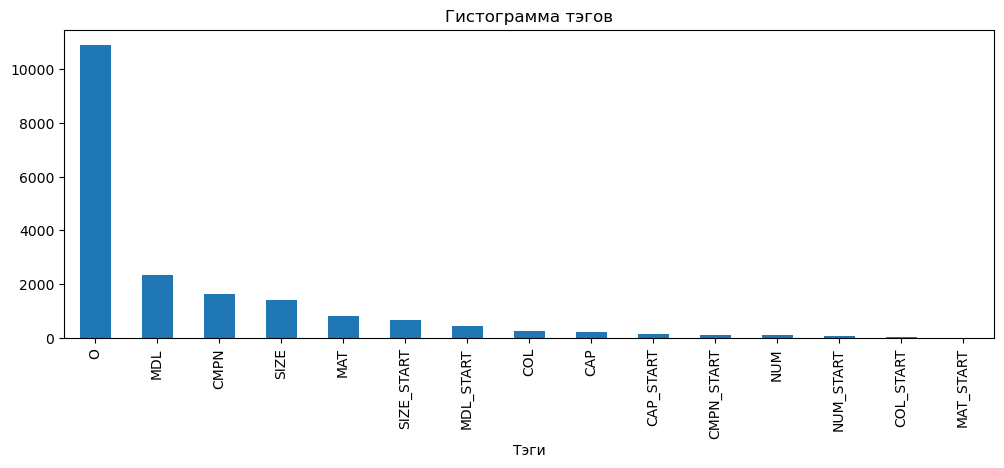

In [36]:
df['Tag'].value_counts().plot.bar(figsize=(12, 4))
plt.title('Гистограмма тэгов')
plt.xlabel('Тэги')
plt.show()

#### Приведение датафрейма к нужной форме

In [37]:
first_dataframe = df.groupby('Title')['Tag'].apply(list).reset_index()
words = df.groupby('Title')['Words'].apply(list).reset_index()['Words']
first_dataframe['Words'] = words
first_dataframe

,Title,Tag,Words
0,"0,4 m z=160 20° дисковый долбяк кл. А Р18*","[SIZE_START, SIZE, O, O, O, O, O, O, O]","[0,4, m, z=160, 20°, дисковый, долбяк, кл, А, ..."
1,"0,8 m z=80 20° дисковый долбяк кл. В Р18*","[SIZE_START, SIZE, O, O, O, O, O, O, MDL]","[0,8, m, z=80, 20°, дисковый, долбяк, кл, В, Р18]"
2,"0204.АЛЮМИНИЕВЫЕ РАДИАТОРЫ 80Х500 ""B2""","[MAT, O, SIZE, MDL]","[0204.АЛЮМИНИЕВЫЕ, РАДИАТОРЫ, 80Х500, B2]"
3,1.1.5 Кольцо бетонное КС 10.3. серия 3.900.1-14,"[O, O, MAT, O, O, O, MDL]","[1.1.5, Кольцо, бетонное, КС, 10.3., серия, 3...."
4,1.1.83 Плита перекрытия колодца ПП 10.2 (усилен.),"[MDL, O, O, O, O, MDL, O]","[1.1.83, Плита, перекрытия, колодца, ПП, 10.2,..."
...,...,...,...
2492,лампа энергосберегающая Tdm Sp E27 20W 6500 10...,"[O, O, CMPN, O, O, O, O, O, O, O, O, MDL]","[лампа, энергосберегающая, Tdm, Sp, E27, 20W, ..."
2493,мМисУзРоНК. Что скрывают зеркала. Калинина Н.Д.,"[O, O, O, O, O, O]","[мМисУзРоНК, Что, скрывают, зеркала, Калинина,..."
2494,"сверло по металлу, ЗУБР, ТЕХНИК, 4-29605-109-7.5","[O, O, O, CMPN, MDL_START, MDL]","[сверло, по, металлу, ЗУБР, ТЕХНИК, 4-29605-10..."
2495,услуги грузчиков и разнорабочих,"[O, O, O, O]","[услуги, грузчиков, и, разнорабочих]"


#### Класс, который объединяет в себе Vocabulary и Vectorizer

In [38]:
class VocabVectorize:
    pad = "<PAD>"
    unk = "<UNK>"
    titles = []
    
    def __init__(self, titles, tags):
        titles = titles.apply(lambda x: self.tokenize(x)).explode().value_counts().index  #уникальные названия
        max_len = max([len(val) for val in titles]) 
        self.alphabet = [VocabVectorize.pad, VocabVectorize.unk, *titles] #создание словаря, с учетом <UNK>, <PAD>
        self.max_len = max_len
        text2seq = {word: i for i, word in enumerate(self.alphabet)} 
        self.seq2text = {i: word for i, word in enumerate(self.alphabet)}
        unknown_idx =  text2seq[VocabVectorize.unk]
        self.text2seq = defaultdict(lambda: unknown_idx,  text2seq)
        tags = tags.explode().value_counts().index
        self.alphabet_tags = [*tags]
        self.tag2seq = {word: i for i, word in enumerate(self.alphabet_tags)}
        self.seq2tag = {i: word for i, word in enumerate(self.alphabet_tags)}
        
    def __len__(self):
        return len(self.alphabet)
    
    def tokenize(self, text):
        return list(filter(lambda y: not is_punctuation(y) and y != '``', nltk.word_tokenize(text.lower())))
    
    #преобразует название товара в вектор, который дополняется пэддингами до длины максимального названия
    def encode(self, text):
        no_pad = list(map(lambda x: self.text2seq[x], self.tokenize(text)))
        len_pad = self.max_len - len(no_pad)
        attention_mask = torch.tensor([1] * len(no_pad) + [0] * len_pad).long()
        return torch.tensor(no_pad + [self.text2seq['<PAD>']]*len_pad), attention_mask
    
    #преобразует вектор в название товара, убирая все пэддинги
    def decode(self, encode_text):
        with_pad = list(map(self.seq2text.get, encode_text.tolist()))
        return ' '.join(list(filter(lambda x: x != '<PAD>', with_pad))) 
    
    #преобразует тэг в вектор
    def tag_encode(self, tags):
        encoded_tag = torch.tensor(list(map(self.tag2seq.get, tags + ['O']*(self.max_len - len(tags)))))
        return encoded_tag
    
    #преобразует векторное представление тэгов в символьное
    def tag_decode(self, encode_tag, encode_text):
        decoded_tag = list(map(self.seq2tag.get, encode_tag[encode_text != 0].tolist()))
        return decoded_tag

In [39]:
vocab = VocabVectorize(first_dataframe['Title'], first_dataframe['Tag'])
vocab.max_len

33

#### Класс, который нужен для дальнейшего использования DataLoader

In [40]:
class DataSet(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
        self.max_len = self.vocab.max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        x, attention_mask = self.vocab.encode(self.data.iloc[i]['Title'])  
        y = self.vocab.tag_encode(self.data.iloc[i]['Tag'])
        return x, y, attention_mask

In [41]:
dataset = DataSet(first_dataframe, vocab)

#### Разбиение датасетов на train, val, test

In [42]:
ratio = 0.2
num_test =  int(ratio * len(dataset))
num_train = len(dataset) - num_test
train_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_test])

num_valid =  int(ratio * len(train_dataset))
num_train = len(train_dataset) - num_valid
train_dataset, valid_dataset = random_split(train_dataset, lengths=[num_train, num_valid])

In [43]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

#### Определение девайса, на котором будут происходить дальнейшие вычисления

In [44]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Дообучение модели BertForTokenClassification

#### Импорт модели

In [45]:
class BertModel(torch.nn.Module):
    def __init__(self, unique_labels):
        super(BertModel, self).__init__()
        self.bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=unique_labels)

    def forward(self, input_id, mask, label):
        output = self.bert(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)
        return output

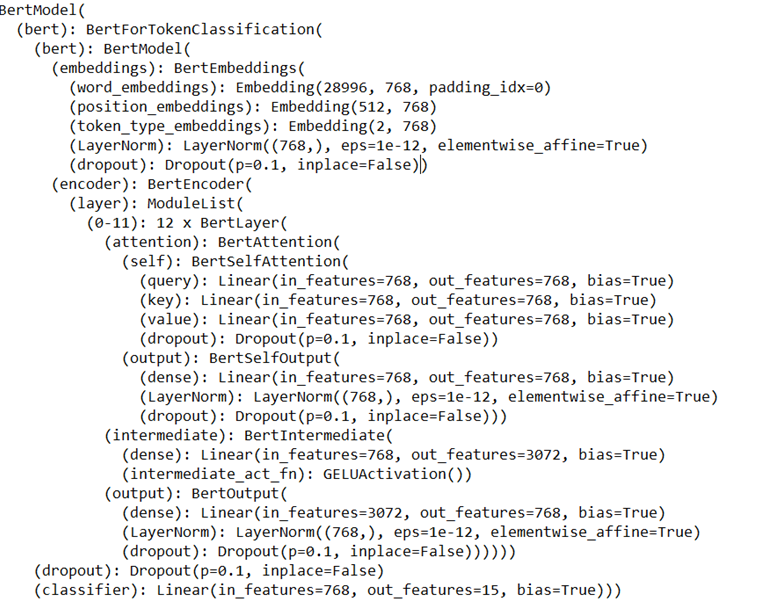

#### Цикл обучения

In [46]:
def train_loop(model, train_dataloader, val_dataloader, batch_size):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    if use_cuda:
        model = model.cuda()
        
    train_losses = []
    train_acc = []
    train_f1 = []
    val_losses = []
    val_acc = []
    val_f1 = []
    for epoch_num in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0
        model.train()
        true = []
        pred = []
        for train_data, train_label, attention_mask in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = attention_mask.to(device)
            input_id = train_data.to(device)
            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)
            for i in range(logits.shape[0]):
                predictions = logits[i].argmax(dim=1)
                pred.append(predictions[mask[i]])
                true.append(train_label[i][mask[i]])
                acc = (predictions[mask[i]] == train_label[i][mask[i]]).float().mean()
                total_acc_train += acc
                total_loss_train += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(total_loss_train / (len(train_dataloader) * batch_size))
        train_acc.append(total_acc_train.cpu() / (len(train_dataloader) * batch_size))
        f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')
        train_f1.append(f1)
        model.eval()
        total_acc_val = 0
        total_loss_val = 0
        true = []
        pred = []
        for val_data, val_label, attention_mask in val_dataloader:
            val_label = val_label.to(device)
            mask = attention_mask.to(device)
            input_id = val_data.to(device)
            loss, logits = model(input_id, mask, val_label)
            for i in range(logits.shape[0]):
                predictions = logits[i].argmax(dim=1)
                pred.append(predictions[mask[i]])
                true.append(val_label[i][mask[i]])
                acc = (predictions[mask[i]] == val_label[i][mask[i]]).float().mean()
                total_acc_val += acc
                total_loss_val += loss.item()
        val_accuracy = total_acc_val.cpu() / (len(val_dataloader) * batch_size)
        val_loss = total_loss_val / (len(val_dataloader) * batch_size)
        f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')
        val_losses.append(val_loss)
        val_acc.append(val_accuracy)
        val_f1.append(f1)
        print(f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / (len(train_dataloader) * batch_size): .3f} | Accuracy: {total_acc_train / (len(train_dataloader) * batch_size): .3f} | F1 Score {train_f1[-1]: .3f} | Val_Loss: {val_loss: .3f} | Val Accuracy: {val_accuracy: .3f} | Val F1 Score: {f1: .3f}')
        
    return train_losses, train_acc, train_f1, val_losses, val_acc, val_f1

In [47]:
LEARNING_RATE = 0.00005
EPOCHS = 15
unique_labels = len(vocab.tag2seq.keys())

#### Обучение 5 моделей (для дополнительной разметки)

In [48]:
def train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
    model = BertModel(unique_labels)
    train_losses, train_acc, train_f1, val_losses, val_acc, val_f1 = train_loop(model, train_loader, valid_loader, batch_size)
    torch.save(model, file_name)
    torch.cuda.empty_cache()
    del train_loader  
    del valid_loader
    del model
    return train_losses, train_acc, train_f1, val_losses, val_acc, val_f1

In [49]:
train_losses_1, train_acc_1, train_f1_1, val_losses_1, val_acc_1, val_f1_1 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_1.pth')
train_losses_2, train_acc_2, train_f1_2, val_losses_2, val_acc_2, val_f1_2 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_2.pth')
train_losses_3, train_acc_3, train_f1_3, val_losses_3, val_acc_3, val_f1_3 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_3.pth')
train_losses_4, train_acc_4, train_f1_4, val_losses_4, val_acc_4, val_f1_4 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_4.pth')
train_losses_5, train_acc_5, train_f1_5, val_losses_5, val_acc_5, val_f1_5 = train_Bert(train_dataset, valid_dataset, batch_size, unique_labels, file_name='model_5.pth')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epochs: 1 | Loss:  0.429 | Accuracy:  0.879 | F1 Score  0.074 | Val_Loss:  0.346 | Val Accuracy:  0.882 | Val F1 Score:  0.101


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.53it/s]


Epochs: 2 | Loss:  0.337 | Accuracy:  0.884 | F1 Score  0.090 | Val_Loss:  0.331 | Val Accuracy:  0.889 | Val F1 Score:  0.121


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:24<00:00,  8.01it/s]


Epochs: 3 | Loss:  0.307 | Accuracy:  0.887 | F1 Score  0.109 | Val_Loss:  0.298 | Val Accuracy:  0.895 | Val F1 Score:  0.136


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:26<00:00,  7.57it/s]


Epochs: 4 | Loss:  0.257 | Accuracy:  0.897 | F1 Score  0.136 | Val_Loss:  0.282 | Val Accuracy:  0.903 | Val F1 Score:  0.182


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:26<00:00,  7.64it/s]


Epochs: 5 | Loss:  0.213 | Accuracy:  0.912 | F1 Score  0.204 | Val_Loss:  0.253 | Val Accuracy:  0.910 | Val F1 Score:  0.219


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:26<00:00,  7.47it/s]


Epochs: 6 | Loss:  0.171 | Accuracy:  0.923 | F1 Score  0.322 | Val_Loss:  0.246 | Val Accuracy:  0.916 | Val F1 Score:  0.279


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:26<00:00,  7.44it/s]


Epochs: 7 | Loss:  0.139 | Accuracy:  0.931 | F1 Score  0.339 | Val_Loss:  0.234 | Val Accuracy:  0.922 | Val F1 Score:  0.308


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.35it/s]


Epochs: 8 | Loss:  0.112 | Accuracy:  0.937 | F1 Score  0.389 | Val_Loss:  0.253 | Val Accuracy:  0.924 | Val F1 Score:  0.342


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.30it/s]


Epochs: 9 | Loss:  0.089 | Accuracy:  0.949 | F1 Score  0.447 | Val_Loss:  0.240 | Val Accuracy:  0.926 | Val F1 Score:  0.336


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.16it/s]


Epochs: 10 | Loss:  0.068 | Accuracy:  0.956 | F1 Score  0.527 | Val_Loss:  0.249 | Val Accuracy:  0.944 | Val F1 Score:  0.372


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.00it/s]


Epochs: 11 | Loss:  0.055 | Accuracy:  0.966 | F1 Score  0.660 | Val_Loss:  0.272 | Val Accuracy:  0.931 | Val F1 Score:  0.350


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.03it/s]


Epochs: 12 | Loss:  0.046 | Accuracy:  0.969 | F1 Score  0.578 | Val_Loss:  0.270 | Val Accuracy:  0.939 | Val F1 Score:  0.350


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.05it/s]


Epochs: 13 | Loss:  0.038 | Accuracy:  0.978 | F1 Score  0.733 | Val_Loss:  0.294 | Val Accuracy:  0.934 | Val F1 Score:  0.346


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.15it/s]


Epochs: 14 | Loss:  0.032 | Accuracy:  0.973 | F1 Score  0.855 | Val_Loss:  0.291 | Val Accuracy:  0.933 | Val F1 Score:  0.358


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.07it/s]


Epochs: 15 | Loss:  0.029 | Accuracy:  0.986 | F1 Score  0.872 | Val_Loss:  0.290 | Val Accuracy:  0.940 | Val F1 Score:  0.363


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epochs: 1 | Loss:  0.436 | Accuracy:  0.879 | F1 Score  0.074 | Val_Loss:  0.342 | Val Accuracy:  0.886 | Val F1 Score:  0.106


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.20it/s]


Epochs: 2 | Loss:  0.319 | Accuracy:  0.884 | F1 Score  0.087 | Val_Loss:  0.306 | Val Accuracy:  0.891 | Val F1 Score:  0.116


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.00it/s]


Epochs: 3 | Loss:  0.262 | Accuracy:  0.893 | F1 Score  0.126 | Val_Loss:  0.268 | Val Accuracy:  0.902 | Val F1 Score:  0.172


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.11it/s]


Epochs: 4 | Loss:  0.221 | Accuracy:  0.907 | F1 Score  0.182 | Val_Loss:  0.262 | Val Accuracy:  0.911 | Val F1 Score:  0.223


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.14it/s]


Epochs: 5 | Loss:  0.173 | Accuracy:  0.921 | F1 Score  0.263 | Val_Loss:  0.244 | Val Accuracy:  0.912 | Val F1 Score:  0.240


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.14it/s]


Epochs: 6 | Loss:  0.137 | Accuracy:  0.929 | F1 Score  0.314 | Val_Loss:  0.246 | Val Accuracy:  0.920 | Val F1 Score:  0.294


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.07it/s]


Epochs: 7 | Loss:  0.107 | Accuracy:  0.939 | F1 Score  0.376 | Val_Loss:  0.246 | Val Accuracy:  0.923 | Val F1 Score:  0.345


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.30it/s]


Epochs: 8 | Loss:  0.081 | Accuracy:  0.954 | F1 Score  0.535 | Val_Loss:  0.236 | Val Accuracy:  0.923 | Val F1 Score:  0.341


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.87it/s]


Epochs: 9 | Loss:  0.067 | Accuracy:  0.959 | F1 Score  0.575 | Val_Loss:  0.238 | Val Accuracy:  0.935 | Val F1 Score:  0.364


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.06it/s]


Epochs: 10 | Loss:  0.052 | Accuracy:  0.974 | F1 Score  0.596 | Val_Loss:  0.270 | Val Accuracy:  0.937 | Val F1 Score:  0.369


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.06it/s]


Epochs: 11 | Loss:  0.042 | Accuracy:  0.974 | F1 Score  0.688 | Val_Loss:  0.248 | Val Accuracy:  0.940 | Val F1 Score:  0.390


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.12it/s]


Epochs: 12 | Loss:  0.035 | Accuracy:  0.978 | F1 Score  0.797 | Val_Loss:  0.279 | Val Accuracy:  0.934 | Val F1 Score:  0.305


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.04it/s]


Epochs: 13 | Loss:  0.031 | Accuracy:  0.981 | F1 Score  0.826 | Val_Loss:  0.306 | Val Accuracy:  0.935 | Val F1 Score:  0.396


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.93it/s]


Epochs: 14 | Loss:  0.023 | Accuracy:  0.986 | F1 Score  0.911 | Val_Loss:  0.285 | Val Accuracy:  0.928 | Val F1 Score:  0.362


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.87it/s]


Epochs: 15 | Loss:  0.024 | Accuracy:  0.985 | F1 Score  0.859 | Val_Loss:  0.298 | Val Accuracy:  0.934 | Val F1 Score:  0.305


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epochs: 1 | Loss:  0.458 | Accuracy:  0.880 | F1 Score  0.068 | Val_Loss:  0.348 | Val Accuracy:  0.886 | Val F1 Score:  0.112


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.10it/s]


Epochs: 2 | Loss:  0.329 | Accuracy:  0.884 | F1 Score  0.087 | Val_Loss:  0.330 | Val Accuracy:  0.885 | Val F1 Score:  0.136


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.06it/s]


Epochs: 3 | Loss:  0.288 | Accuracy:  0.888 | F1 Score  0.119 | Val_Loss:  0.309 | Val Accuracy:  0.890 | Val F1 Score:  0.153


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.06it/s]


Epochs: 4 | Loss:  0.251 | Accuracy:  0.902 | F1 Score  0.163 | Val_Loss:  0.260 | Val Accuracy:  0.906 | Val F1 Score:  0.185


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.95it/s]


Epochs: 5 | Loss:  0.210 | Accuracy:  0.910 | F1 Score  0.196 | Val_Loss:  0.258 | Val Accuracy:  0.904 | Val F1 Score:  0.182


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.17it/s]


Epochs: 6 | Loss:  0.170 | Accuracy:  0.921 | F1 Score  0.272 | Val_Loss:  0.241 | Val Accuracy:  0.916 | Val F1 Score:  0.262


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.97it/s]


Epochs: 7 | Loss:  0.140 | Accuracy:  0.926 | F1 Score  0.301 | Val_Loss:  0.255 | Val Accuracy:  0.910 | Val F1 Score:  0.268


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.07it/s]


Epochs: 8 | Loss:  0.111 | Accuracy:  0.935 | F1 Score  0.429 | Val_Loss:  0.243 | Val Accuracy:  0.921 | Val F1 Score:  0.387


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.17it/s]


Epochs: 9 | Loss:  0.093 | Accuracy:  0.943 | F1 Score  0.426 | Val_Loss:  0.251 | Val Accuracy:  0.922 | Val F1 Score:  0.360


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.07it/s]


Epochs: 10 | Loss:  0.071 | Accuracy:  0.949 | F1 Score  0.534 | Val_Loss:  0.236 | Val Accuracy:  0.933 | Val F1 Score:  0.370


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.75it/s]


Epochs: 11 | Loss:  0.060 | Accuracy:  0.957 | F1 Score  0.553 | Val_Loss:  0.262 | Val Accuracy:  0.929 | Val F1 Score:  0.407


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.07it/s]


Epochs: 12 | Loss:  0.050 | Accuracy:  0.964 | F1 Score  0.619 | Val_Loss:  0.249 | Val Accuracy:  0.941 | Val F1 Score:  0.424


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.11it/s]


Epochs: 13 | Loss:  0.043 | Accuracy:  0.972 | F1 Score  0.798 | Val_Loss:  0.246 | Val Accuracy:  0.929 | Val F1 Score:  0.402


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.91it/s]


Epochs: 14 | Loss:  0.037 | Accuracy:  0.970 | F1 Score  0.754 | Val_Loss:  0.281 | Val Accuracy:  0.936 | Val F1 Score:  0.399


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.98it/s]


Epochs: 15 | Loss:  0.032 | Accuracy:  0.982 | F1 Score  0.862 | Val_Loss:  0.282 | Val Accuracy:  0.937 | Val F1 Score:  0.405


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epochs: 1 | Loss:  0.436 | Accuracy:  0.877 | F1 Score  0.079 | Val_Loss:  0.362 | Val Accuracy:  0.887 | Val F1 Score:  0.094


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.04it/s]


Epochs: 2 | Loss:  0.337 | Accuracy:  0.882 | F1 Score  0.081 | Val_Loss:  0.335 | Val Accuracy:  0.888 | Val F1 Score:  0.122


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.08it/s]


Epochs: 3 | Loss:  0.312 | Accuracy:  0.885 | F1 Score  0.101 | Val_Loss:  0.316 | Val Accuracy:  0.890 | Val F1 Score:  0.122


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.15it/s]


Epochs: 4 | Loss:  0.277 | Accuracy:  0.895 | F1 Score  0.132 | Val_Loss:  0.304 | Val Accuracy:  0.902 | Val F1 Score:  0.177


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.15it/s]


Epochs: 5 | Loss:  0.229 | Accuracy:  0.909 | F1 Score  0.177 | Val_Loss:  0.263 | Val Accuracy:  0.911 | Val F1 Score:  0.224


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.25it/s]


Epochs: 6 | Loss:  0.190 | Accuracy:  0.918 | F1 Score  0.219 | Val_Loss:  0.248 | Val Accuracy:  0.911 | Val F1 Score:  0.245


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.11it/s]


Epochs: 7 | Loss:  0.152 | Accuracy:  0.926 | F1 Score  0.279 | Val_Loss:  0.250 | Val Accuracy:  0.910 | Val F1 Score:  0.212


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.03it/s]


Epochs: 8 | Loss:  0.116 | Accuracy:  0.937 | F1 Score  0.347 | Val_Loss:  0.229 | Val Accuracy:  0.922 | Val F1 Score:  0.305


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.13it/s]


Epochs: 9 | Loss:  0.096 | Accuracy:  0.943 | F1 Score  0.468 | Val_Loss:  0.233 | Val Accuracy:  0.923 | Val F1 Score:  0.355


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.26it/s]


Epochs: 10 | Loss:  0.075 | Accuracy:  0.959 | F1 Score  0.446 | Val_Loss:  0.242 | Val Accuracy:  0.932 | Val F1 Score:  0.363


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.09it/s]


Epochs: 11 | Loss:  0.060 | Accuracy:  0.960 | F1 Score  0.649 | Val_Loss:  0.257 | Val Accuracy:  0.932 | Val F1 Score:  0.360


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.01it/s]


Epochs: 12 | Loss:  0.058 | Accuracy:  0.965 | F1 Score  0.624 | Val_Loss:  0.250 | Val Accuracy:  0.923 | Val F1 Score:  0.375


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.03it/s]


Epochs: 13 | Loss:  0.041 | Accuracy:  0.975 | F1 Score  0.756 | Val_Loss:  0.280 | Val Accuracy:  0.925 | Val F1 Score:  0.349


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.18it/s]


Epochs: 14 | Loss:  0.033 | Accuracy:  0.979 | F1 Score  0.831 | Val_Loss:  0.324 | Val Accuracy:  0.933 | Val F1 Score:  0.366


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.09it/s]


Epochs: 15 | Loss:  0.032 | Accuracy:  0.981 | F1 Score  0.866 | Val_Loss:  0.271 | Val Accuracy:  0.941 | Val F1 Score:  0.371


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Epochs: 1 | Loss:  0.470 | Accuracy:  0.880 | F1 Score  0.072 | Val_Loss:  0.364 | Val Accuracy:  0.886 | Val F1 Score:  0.095


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.70it/s]


Epochs: 2 | Loss:  0.342 | Accuracy:  0.882 | F1 Score  0.083 | Val_Loss:  0.339 | Val Accuracy:  0.886 | Val F1 Score:  0.108


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.90it/s]


Epochs: 3 | Loss:  0.313 | Accuracy:  0.885 | F1 Score  0.092 | Val_Loss:  0.306 | Val Accuracy:  0.889 | Val F1 Score:  0.123


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:29<00:00,  6.85it/s]


Epochs: 4 | Loss:  0.269 | Accuracy:  0.888 | F1 Score  0.116 | Val_Loss:  0.279 | Val Accuracy:  0.889 | Val F1 Score:  0.131


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.99it/s]


Epochs: 5 | Loss:  0.223 | Accuracy:  0.898 | F1 Score  0.169 | Val_Loss:  0.250 | Val Accuracy:  0.901 | Val F1 Score:  0.190


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.12it/s]


Epochs: 6 | Loss:  0.177 | Accuracy:  0.915 | F1 Score  0.263 | Val_Loss:  0.246 | Val Accuracy:  0.913 | Val F1 Score:  0.233


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.06it/s]


Epochs: 7 | Loss:  0.141 | Accuracy:  0.926 | F1 Score  0.311 | Val_Loss:  0.235 | Val Accuracy:  0.919 | Val F1 Score:  0.347


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.13it/s]


Epochs: 8 | Loss:  0.109 | Accuracy:  0.942 | F1 Score  0.428 | Val_Loss:  0.259 | Val Accuracy:  0.932 | Val F1 Score:  0.365


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.15it/s]


Epochs: 9 | Loss:  0.086 | Accuracy:  0.948 | F1 Score  0.448 | Val_Loss:  0.256 | Val Accuracy:  0.929 | Val F1 Score:  0.361


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  7.05it/s]


Epochs: 10 | Loss:  0.070 | Accuracy:  0.958 | F1 Score  0.621 | Val_Loss:  0.259 | Val Accuracy:  0.929 | Val F1 Score:  0.347


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.16it/s]


Epochs: 11 | Loss:  0.057 | Accuracy:  0.961 | F1 Score  0.679 | Val_Loss:  0.273 | Val Accuracy:  0.930 | Val F1 Score:  0.365


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.97it/s]


Epochs: 12 | Loss:  0.047 | Accuracy:  0.973 | F1 Score  0.728 | Val_Loss:  0.262 | Val Accuracy:  0.927 | Val F1 Score:  0.367


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:28<00:00,  6.88it/s]


Epochs: 13 | Loss:  0.038 | Accuracy:  0.978 | F1 Score  0.780 | Val_Loss:  0.286 | Val Accuracy:  0.939 | Val F1 Score:  0.410


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.11it/s]


Epochs: 14 | Loss:  0.031 | Accuracy:  0.982 | F1 Score  0.751 | Val_Loss:  0.266 | Val Accuracy:  0.939 | Val F1 Score:  0.370


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [00:27<00:00,  7.17it/s]


Epochs: 15 | Loss:  0.024 | Accuracy:  0.984 | F1 Score  0.915 | Val_Loss:  0.316 | Val Accuracy:  0.940 | Val F1 Score:  0.376


#### Результаты обучения каждой из 5 моделей

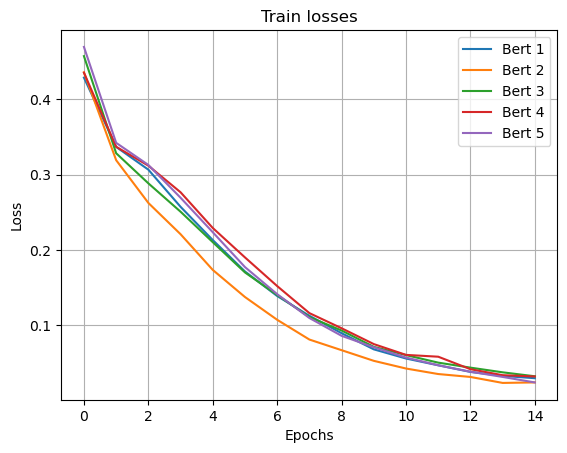

In [50]:
plt.plot(train_losses_1, label='Bert 1')
plt.plot(train_losses_2, label='Bert 2')
plt.plot(train_losses_3, label='Bert 3')
plt.plot(train_losses_4, label='Bert 4')
plt.plot(train_losses_5, label='Bert 5')
plt.title('Train losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

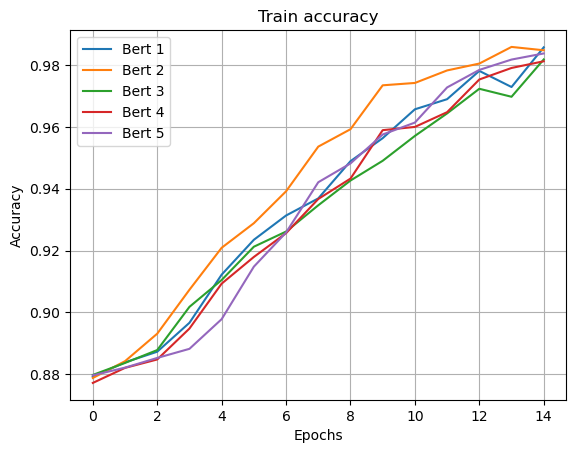

In [51]:
plt.plot(list(map(lambda x: x.cpu(), train_acc_1)), label='Bert 1')
plt.plot(list(map(lambda x: x.cpu(), train_acc_2)), label='Bert 2')
plt.plot(list(map(lambda x: x.cpu(), train_acc_3)), label='Bert 3')
plt.plot(list(map(lambda x: x.cpu(), train_acc_4)), label='Bert 4')
plt.plot(list(map(lambda x: x.cpu(), train_acc_5)), label='Bert 5')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

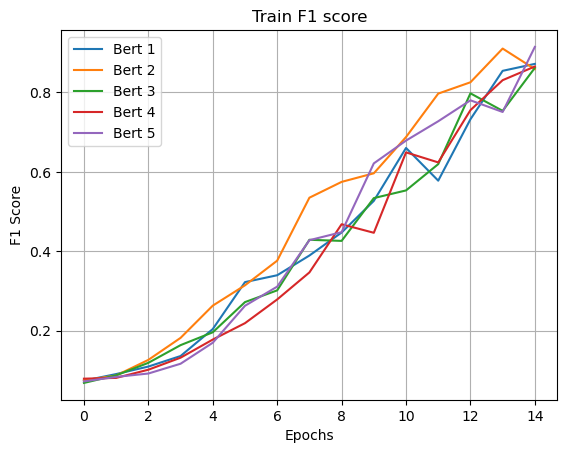

In [52]:
plt.plot(train_f1_1, label='Bert 1')
plt.plot(train_f1_2, label='Bert 2')
plt.plot(train_f1_3, label='Bert 3')
plt.plot(train_f1_4, label='Bert 4')
plt.plot(train_f1_5, label='Bert 5')
plt.title('Train F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

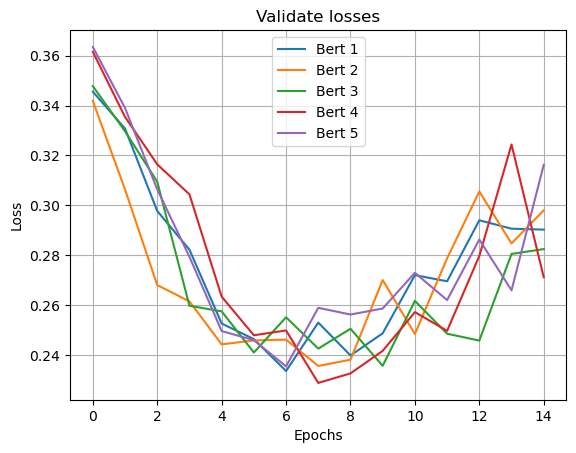

In [53]:
plt.plot(val_losses_1, label='Bert 1')
plt.plot(val_losses_2, label='Bert 2')
plt.plot(val_losses_3, label='Bert 3')
plt.plot(val_losses_4, label='Bert 4')
plt.plot(val_losses_5, label='Bert 5')
plt.title('Validate losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

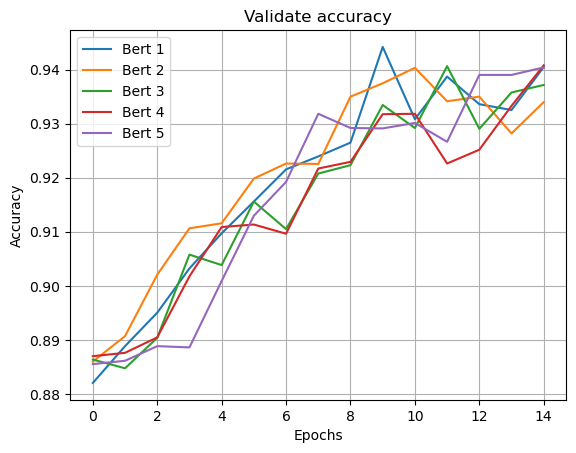

In [54]:
plt.plot(list(map(lambda x: x.cpu(), val_acc_1)), label='Bert 1')
plt.plot(list(map(lambda x: x.cpu(), val_acc_2)), label='Bert 2')
plt.plot(list(map(lambda x: x.cpu(), val_acc_3)), label='Bert 3')
plt.plot(list(map(lambda x: x.cpu(), val_acc_4)), label='Bert 4')
plt.plot(list(map(lambda x: x.cpu(), val_acc_5)), label='Bert 5')
plt.title('Validate accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

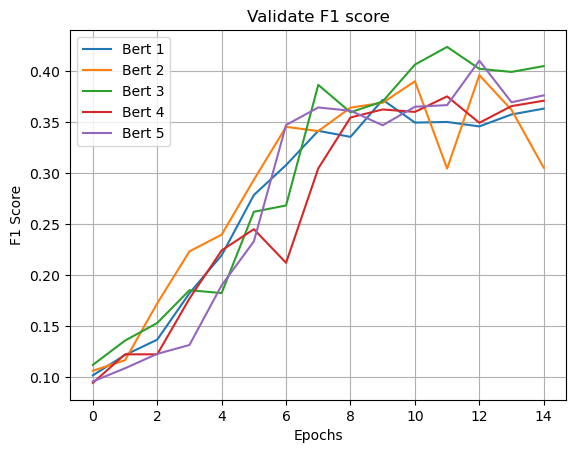

In [55]:
plt.plot(val_f1_1, label='Bert 1')
plt.plot(val_f1_2, label='Bert 2')
plt.plot(val_f1_3, label='Bert 3')
plt.plot(val_f1_4, label='Bert 4')
plt.plot(val_f1_5, label='Bert 5')
plt.title('Validate F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

In [56]:
def bert_test(model, test_dataloader, batch_size):
    model.eval()
    total_acc_test = 0
    total_loss_test = 0
    true = []
    pred = []
    for test_data, test_label, attention_mask in test_dataloader:
        test_label = test_label.to(device)
        mask = attention_mask.to(device)
        input_id = test_data.to(device)
        loss, logits = model(input_id, mask, test_label)
        for i in range(logits.shape[0]):
            predictions = logits[i].argmax(dim=1)
            true.append(predictions[mask[i]])
            pred.append(test_label[i][mask[i]])
            acc = (predictions[mask[i]] == test_label[i][mask[i]]).float().mean()
            total_acc_test += acc
            total_loss_test += loss.item()
    test_accuracy = total_acc_test / (len(test_dataloader) * batch_size)
    test_loss = total_loss_test / (len(test_dataloader) * batch_size)
    f1 = f1_score(torch.concat(true).cpu(), torch.concat(pred).cpu(), average='macro')

    print(f'TEST | Loss: {test_loss: .3f} | Accuracy: {test_accuracy: .3f} | F1 Score: {f1: .3f}')

In [57]:
model_1 = torch.load('model_1.pth').to(device)
bert_test(model_1, test_loader, batch_size)

TEST | Loss:  0.289 | Accuracy:  0.931 | F1 Score:  0.472


## Дополнительная разметка данных

In [58]:
big = pd.read_excel('for_bert_excel.xlsx')

####  Разметка новых данных методом голосования моделей

In [59]:
titles = []
tags_list = []
model_1 = torch.load('model_1.pth').to(device)
model_2 = torch.load('model_2.pth').to(device)
model_3 = torch.load('model_3.pth').to(device)
model_4 = torch.load('model_4.pth').to(device)
model_5 = torch.load('model_5.pth').to(device)

with torch.no_grad():
    for title in tqdm(big['Title']):
        token, att_mask = vocab.encode(title)
        preds = []
        for model in [model_1, model_2, model_3, model_4, model_5]:
            #делаем предсказание на каждой из моделей
            loss, pred = model(token.unsqueeze(0).to(device), att_mask.unsqueeze(0).to(device), torch.zeros(1, len(token)).long().to(device))
            preds.append(pred.argmax(dim=2)[0])
        preds = torch.concat(preds).reshape(5, -1)
        preds = torch.mode(preds, dim=0).values  #для каждого токена выбираем самый популярный из 5 
        tag = vocab.tag_decode(preds, token)
        titles.append(title)
        tags_list.append(tag)
        torch.cuda.empty_cache()   #очищение кэша, чтобы оперативная память не переполнялась
print(titles[0], tags_list[0])

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [18:51<00:00, 13.26it/s]

Лотки и плиты теплотрассы П24д-8 ['O', 'O', 'O', 'O', 'MDL']


#### Визуализация решения задачи NER

In [60]:
def visualize_ner(words, tags):
    colors = {
        'MDL': '\033[31m',    #слово из каждой категории выводится таким цветом, как его тэг
        'CMPN': '\033[4m',
        'SIZE': '\033[32m',
        'MAT': '\033[33m',
        'COL': '\033[34m',
        'CAP': '\033[35m',
        'NUM': '\033[36m'
    }
    blank = '\033[0m'         #после выделения слова определенным цветом форматирование обнуляется, чтобы не окрасить лишнее
    res = ''.join([v + k + blank + '\n' for k, v in colors.items()])
    for i in range(len(words)):
        for token, label in zip(words[i], tags[i]):
            tag = label.split('_')[0]
            res += colors.get(tag, blank) + token + blank + ' '
        res += '\n'
    print(res)

In [61]:
custom_title = ['Насос дренажный PATRIOT FQ1200N  1200 Вт, 18000 л/час',
                '1.1.83 Плита перекрытия колодца ПП 10.2 (усилен.)',
                'Плита перекрытия П1 по серии ИС-01-04, вып.2',
                'фанера большеформатная ФК и ФСФ',
                'Краска для бетона Monopol Color цвет синий'
               ]
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
mask = torch.concat(list(map(lambda x: vocab.encode(x)[1], custom_title))).reshape(len(custom_title), -1)
y = torch.zeros(len(custom_title), len(X[0])).long()
_, pred = model_1(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [62]:
_, pred = model_2(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [63]:
_, pred = model_3(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [64]:
_, pred = model_4(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



In [65]:
_, pred = model_5(X.to(device), mask.to(device), y.to(device))
pred = pred.argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



#### Преобразование файла с дополнительной разметкой в нужный формат

In [66]:
new_dataset = pd.DataFrame({'Title':titles, 'Tag':tags_list})
new_dataset['Words'] = new_dataset['Title'].apply(lambda x: vocab.tokenize(x))
new_dataset

,Title,Tag,Words
0,Лотки и плиты теплотрассы П24д-8,"[O, O, O, O, MDL]","[лотки, и, плиты, теплотрассы, п24д-8]"
1,"Кисть плоская STAYER ""LASUR - LUX"", деревянная...","[O, O, CMPN, O, O, MAT, O, O, MAT, SIZE]","[кисть, плоская, stayer, lasur, lux, деревянна..."
2,"Плита перекрытия П1 по серии ИС-01-04, вып.2","[O, O, O, O, O, MDL, COL]","[плита, перекрытия, п1, по, серии, ис-01-04, в..."
3,Диск пильный по дереву EUROTEX 190х32х36 зубь...,"[O, O, O, O, O, O, O, O, O, O]","[диск, пильный, по, дереву, eurotex, 190х32х36..."
4,Сверло по металлу ЗУБР 4-29605-191-17.5 быстро...,"[O, O, O, CMPN, O, O, MAT, O, O, O, SIZE, SIZE...","[сверло, по, металлу, зубр, 4-29605-191-17.5, ..."
...,...,...,...
14995,"Кисть КМ-55, ГОСТ, L щет.= 89 мм, полиамидная ...","[O, O, O, O, O, SIZE_START, SIZE, O, O]","[кисть, км-55, гост, l, щет.=, 89, мм, полиами..."
14996,Краска для бетона Monopol Color цвет синий фас...,"[O, O, O, CMPN_START, CMPN, O, COL, O, SIZE_ST...","[краска, для, бетона, monopol, color, цвет, си..."
14997,"Колодезные кольца КС 10-9, КС 15-9, КС 20-9","[O, O, O, MAT, O, O, O, O]","[колодезные, кольца, кс, 10-9, кс, 15-9, кс, 2..."
14998,"Ножовка по дереву ЗУБР (пила) ЗУБР 355 мм, 1 п...","[O, O, O, CMPN, O, CMPN, SIZE_START, SIZE, O, O]","[ножовка, по, дереву, зубр, пила, зубр, 355, м..."


In [67]:
new_dataset.to_excel('bert_made.xlsx', index=False)

In [68]:
new_dataset = pd.read_excel('bert_made.xlsx')
new_dataset['Tag'] = new_dataset['Tag'].apply(eval)
new_dataset['Words'] = new_dataset['Words'].apply(eval)
new_dataset

,Title,Tag,Words
0,Лотки и плиты теплотрассы П24д-8,"[O, O, O, O, MDL]","[лотки, и, плиты, теплотрассы, п24д-8]"
1,"Кисть плоская STAYER ""LASUR - LUX"", деревянная...","[O, O, CMPN, O, O, MAT, O, O, MAT, SIZE]","[кисть, плоская, stayer, lasur, lux, деревянна..."
2,"Плита перекрытия П1 по серии ИС-01-04, вып.2","[O, O, O, O, O, MDL, COL]","[плита, перекрытия, п1, по, серии, ис-01-04, в..."
3,Диск пильный по дереву EUROTEX 190х32х36 зубь...,"[O, O, O, O, O, O, O, O, O, O]","[диск, пильный, по, дереву, eurotex, 190х32х36..."
4,Сверло по металлу ЗУБР 4-29605-191-17.5 быстро...,"[O, O, O, CMPN, O, O, MAT, O, O, O, SIZE, SIZE...","[сверло, по, металлу, зубр, 4-29605-191-17.5, ..."
...,...,...,...
14995,"Кисть КМ-55, ГОСТ, L щет.= 89 мм, полиамидная ...","[O, O, O, O, O, SIZE_START, SIZE, O, O]","[кисть, км-55, гост, l, щет.=, 89, мм, полиами..."
14996,Краска для бетона Monopol Color цвет синий фас...,"[O, O, O, CMPN_START, CMPN, O, COL, O, SIZE_ST...","[краска, для, бетона, monopol, color, цвет, си..."
14997,"Колодезные кольца КС 10-9, КС 15-9, КС 20-9","[O, O, O, MAT, O, O, O, O]","[колодезные, кольца, кс, 10-9, кс, 15-9, кс, 2..."
14998,"Ножовка по дереву ЗУБР (пила) ЗУБР 355 мм, 1 п...","[O, O, O, CMPN, O, CMPN, SIZE_START, SIZE, O, O]","[ножовка, по, дереву, зубр, пила, зубр, 355, м..."


In [69]:
visualize_ner(new_dataset['Words'][14995:].values, new_dataset['Tag'][14995:].values)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
кисть км-55 гост l щет.= 89 мм полиамидная обойма 
краска для бетона monopol color цвет синий фасовка 1 л 
колодезные кольца кс 10-9 кс 15-9 кс 20-9 
ножовка по дереву зубр пила зубр 355 мм 1 полотно 
каналы и тоннели сборные железобетонные из лотковых элементов лотки серия 3.006.1-8 изделие лк75.210.120-3 



In [70]:
new_dataset['HandMade'] = 0        #для semi-supervised learning нужно отметить, какие данные были созданы автоматически,
first_dataframe['HandMade'] = 1    #а какие вручную

#### Создание нового "большого" датасета, в котором объединены размеченный вручную и размеченный с помощью 5 моделей BertForTokenClassification

In [71]:
big_dataframe = pd.concat([first_dataframe, new_dataset], ignore_index=True)
big_dataframe.shape

(17497, 4)

#### Демонстрация несбалансированности классов в увеличенном датасете

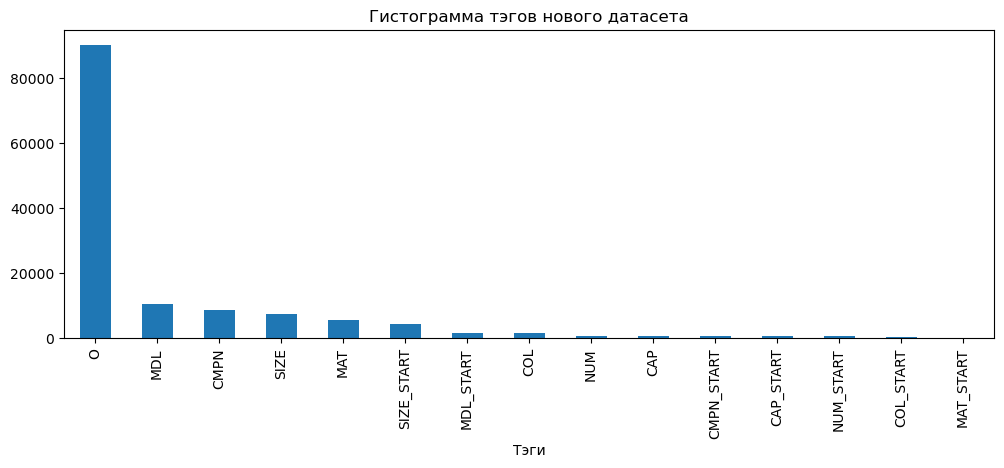

In [72]:
big_dataframe['Tag'].explode().value_counts().plot.bar(figsize=(12, 4))
plt.title('Гистограмма тэгов нового датасета')
plt.xlabel('Тэги')
plt.show()

In [73]:
vocab = VocabVectorize(big_dataframe['Title'], big_dataframe['Tag'])
vocab.max_len

39

#### Адаптированный для semi-supervised learning класс DataSet

In [74]:
class DataSet_hm(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab
        self.max_len = self.vocab.max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        hm = self.data.iloc[i]['HandMade']
        x, attention_mask = self.vocab.encode(self.data.iloc[i]['Title'])
        y = torch.tensor(list(map(self.vocab.tag2seq.get, self.data.iloc[i]['Tag'] + ['O']*(self.max_len - len(self.data.iloc[i]['Tag'])))))
        return x, y, attention_mask, hm

big_dataset = DataSet_hm(big_dataframe, vocab)

## Обучение модели со слоем BI-LSTM

#### Архитектура модели

In [75]:
class NER_LSTM_Model(nn.Module):
    def __init__(self, emb_size, input_size, hidden_size, num_layers, n_classes, input_len):
        super().__init__()
        self.embed = nn.Embedding(input_size + 1, emb_size)
        self.bilstm = nn.LSTM(emb_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm1d(input_len)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.sigmoid = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        out = self.embed(x)
        out = self.dropout(out)
        out, _ = self.bilstm(out)
        out = self.norm(out)
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

#### Создание кастомного класса ошибки, который можно применять на данных, классы которых несбалансированы

In [76]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

$$ \begin{aligned}
C E_i & =-\log p_i \\
e^{-C E_i} & =e^{\log p_i}=p_i \\
F L_i & =\alpha\left(1-p_i\right)^\gamma \cdot \log p_i=\alpha\left(1-e^{-C E_i}\right)^\gamma \cdot C E_i
\end{aligned} $$

#### Функция для обучения второй и третьей моделей

In [77]:
def semi_train(model, loader, loss_function, optimizer):
    model.train()
    epoch_loss = 0
    epoch_predict = []
    epoch_label = []
    N = 0
    beta = 0.2
    for inputs, labels, _, hm in tqdm(loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device)).permute(0, 2, 1)
        loss = 0
        if hm.sum():
            loss += loss_function(outputs[hm.bool()], labels[hm.bool()].to(device)) 
        if ~hm.sum():           #если данные размечены автоматически, то ошибка, связанная с ними, учитывается только на 20%
            loss += beta * loss_function(outputs[~hm.bool()], labels[~hm.bool()].to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        mask = labels != vocab.text2seq.get(VocabVectorize.pad)
        epoch_predict.append(outputs.argmax(dim=1)[mask])
        epoch_label.append(labels[mask])
    return epoch_loss / len(loader), accuracy_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu()), f1_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu(), average='macro')

#### Функция для тестирования второй и третьей моделей

In [78]:
def semi_test(model, loader, loss_function):
    with torch.no_grad():
        model.eval()
        epoch_predict = []
        epoch_label = []
        for inputs, labels, _, _ in tqdm(loader):
            outputs = model(inputs.to(device)).permute(0, 2, 1)
            mask = labels != vocab.text2seq.get(VocabVectorize.pad)
            epoch_predict.append(outputs.argmax(dim=1)[mask])
            epoch_label.append(labels[mask])
        return accuracy_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu()), f1_score(torch.concat(epoch_label).cpu(), torch.concat(epoch_predict).cpu(), average='macro')

In [79]:
input_size = len(vocab.alphabet)
emb_size = 200
hidden_size = 100
num_layers = 3
input_len = vocab.max_len
n_classes = len(vocab.alphabet_tags)

model = NER_LSTM_Model(emb_size, input_size, hidden_size, num_layers, n_classes, input_len).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [80]:
ratio = 0.2
num_test =  int(ratio * len(big_dataset))
num_train = len(big_dataset) - num_test
train_dataset, test_dataset = random_split(big_dataset, lengths=[num_train, num_test])

num_valid =  int(ratio * len(train_dataset))
num_train = len(train_dataset) - num_valid
train_dataset, valid_dataset = random_split(train_dataset, lengths=[num_train, num_valid])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

#### Обучение и тестирование второй модели

In [81]:
num_epochs = 10
train_losses = []
train_accs = []
train_f1s = []
valid_accs = []
valid_f1s = []
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = semi_train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    valid_acc, valid_f1 = semi_test(model, loader=valid_loader, loss_function=criterion)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f}, Train Acc {train_acc:.6f}, Train F1 {train_f1:.6f}')
    print(f'Valid Acc {valid_acc:.6f}, Valid F1 {valid_f1:.6f}')
    print('---')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    torch.cuda.empty_cache()
    
test_acc, test_f1 = semi_test(model=model, loader=test_loader, loss_function=criterion)
print(test_acc, test_f1)

100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 132.50it/s]


Epoch 0
Train Loss 0.145834, Train Acc 0.285126, Train F1 0.212686
Valid Acc 0.558326, Valid F1 0.474702
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 131.35it/s]


Epoch 1
Train Loss 0.077830, Train Acc 0.611950, Train F1 0.568182
Valid Acc 0.678915, Valid F1 0.626612
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 122.50it/s]


Epoch 2
Train Loss 0.051432, Train Acc 0.710027, Train F1 0.692207
Valid Acc 0.757655, Valid F1 0.735998
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:03<00:00, 105.56it/s]


Epoch 3
Train Loss 0.036089, Train Acc 0.754650, Train F1 0.735390
Valid Acc 0.730679, Valid F1 0.710721
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:03<00:00, 106.21it/s]


Epoch 4
Train Loss 0.026919, Train Acc 0.784600, Train F1 0.767316
Valid Acc 0.758968, Valid F1 0.747621
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:03<00:00, 112.18it/s]


Epoch 5
Train Loss 0.021052, Train Acc 0.800678, Train F1 0.775406
Valid Acc 0.778361, Valid F1 0.747512
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 120.55it/s]


Epoch 6
Train Loss 0.017368, Train Acc 0.818410, Train F1 0.790354
Valid Acc 0.771799, Valid F1 0.752750
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 116.57it/s]


Epoch 7
Train Loss 0.016403, Train Acc 0.829093, Train F1 0.799108
Valid Acc 0.778798, Valid F1 0.756228
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 132.40it/s]


Epoch 8
Train Loss 0.012744, Train Acc 0.840639, Train F1 0.815161
Valid Acc 0.780548, Valid F1 0.772525
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 127.05it/s]


Epoch 9
Train Loss 0.011704, Train Acc 0.851455, Train F1 0.818595
Valid Acc 0.784048, Valid F1 0.777808
---


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:04<00:00, 104.87it/s]

0.7880902535473366 0.7713836965799887


#### Визуализация результатов второй модели

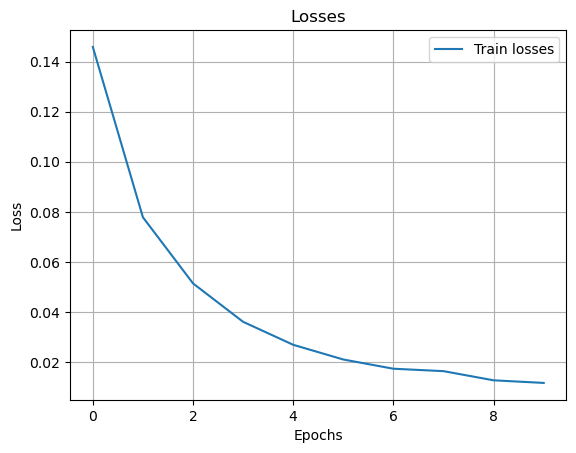

In [82]:
plt.plot(train_losses, label='Train losses')
plt.grid()
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

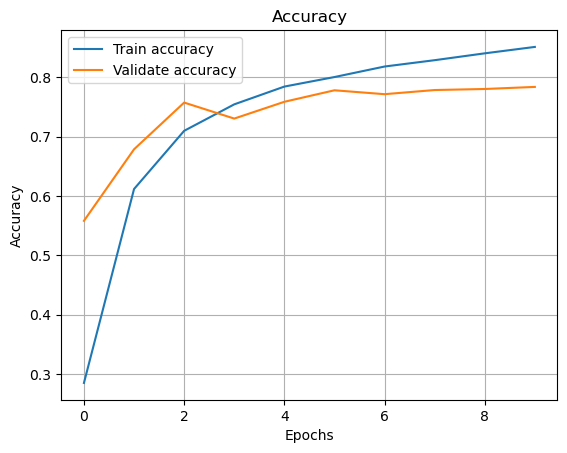

In [83]:
plt.plot(train_accs, label='Train accuracy')
plt.plot(valid_accs, label='Validate accuracy')
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

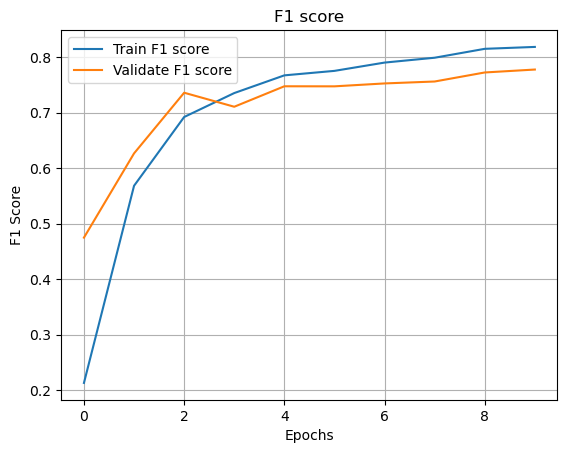

In [84]:
plt.plot(train_f1s, label='Train F1 score')
plt.plot(valid_f1s, label='Validate F1 score')
plt.grid()
plt.title('F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [85]:
torch.save(model, 'final_lstm_model.pth') #Модель и её веса сохраняются для дальнейшего использования, чтобы снова не ждать весь процесс обучения

In [86]:
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
pred = model(X.to(device)).argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 



## Обучение модели со слоем BI-GRU

#### Архитектура модели

In [87]:
class NER_GRU_Model(nn.Module):
    def __init__(self, emb_size, input_size, hidden_size, num_layers, n_classes, input_len):
        super().__init__()
        self.embed = nn.Embedding(input_size + 1, emb_size)
        self.bilstm = nn.GRU(emb_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.norm = nn.BatchNorm1d(input_len)
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.sigmoid = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        out = self.embed(x)
        out = self.dropout(out)
        out, _ = self.bilstm(out)
        out = self.norm(out)
        out = self.fc1(out)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

In [88]:
input_size = len(vocab.alphabet)
emb_size = 200
hidden_size = 100
num_layers = 3
input_len = vocab.max_len
n_classes = len(vocab.alphabet_tags)
model = NER_GRU_Model(emb_size, input_size, hidden_size, num_layers, n_classes, input_len).to(device)
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#### Обучение и тестирование третьей модели

In [89]:
num_epochs = 10
train_losses = []
train_accs = []
train_f1s = []
valid_accs = []
valid_f1s = []
for epoch in range(num_epochs):
    train_loss, train_acc, train_f1 = semi_train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer)
    valid_acc, valid_f1 = semi_test(model, loader=valid_loader, loss_function=criterion)
    print(f'Epoch {epoch}')
    print(f'Train Loss {train_loss:.6f}, Train Acc {train_acc:.6f}, Train F1 {train_f1:.6f}')
    print(f'Valid Acc {valid_acc:.6f}, Valid F1 {valid_f1:.6f}')
    print('---')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    valid_accs.append(valid_acc)
    valid_f1s.append(valid_f1)
    torch.cuda.empty_cache()  
test_acc, test_f1 = semi_test(model=model, loader=test_loader, loss_function=criterion)
print(test_acc, test_f1)

100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:03<00:00, 112.51it/s]


Epoch 0
Train Loss 0.144590, Train Acc 0.271299, Train F1 0.221849
Valid Acc 0.517789, Valid F1 0.420995
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 139.99it/s]


Epoch 1
Train Loss 0.083834, Train Acc 0.578637, Train F1 0.552059
Valid Acc 0.635462, Valid F1 0.648487
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 129.74it/s]


Epoch 2
Train Loss 0.057651, Train Acc 0.682945, Train F1 0.676110
Valid Acc 0.716827, Valid F1 0.703895
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 134.70it/s]


Epoch 3
Train Loss 0.042462, Train Acc 0.727853, Train F1 0.726891
Valid Acc 0.748177, Valid F1 0.724476
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 133.82it/s]


Epoch 4
Train Loss 0.031674, Train Acc 0.757281, Train F1 0.745049
Valid Acc 0.741178, Valid F1 0.706106
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 131.35it/s]


Epoch 5
Train Loss 0.025116, Train Acc 0.782735, Train F1 0.772740
Valid Acc 0.761301, Valid F1 0.745834
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 139.04it/s]


Epoch 6
Train Loss 0.020885, Train Acc 0.800846, Train F1 0.785347
Valid Acc 0.753135, Valid F1 0.745089
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 136.54it/s]


Epoch 7
Train Loss 0.017242, Train Acc 0.813660, Train F1 0.794279
Valid Acc 0.774570, Valid F1 0.731615
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 136.76it/s]


Epoch 8
Train Loss 0.014094, Train Acc 0.826915, Train F1 0.801997
Valid Acc 0.767133, Valid F1 0.754692
---


100%|███████████████████████████████████████████████████████████████████████████████| 349/349 [00:02<00:00, 134.64it/s]


Epoch 9
Train Loss 0.012780, Train Acc 0.838309, Train F1 0.810991
Valid Acc 0.745990, Valid F1 0.742303
---


100%|███████████████████████████████████████████████████████████████████████████████| 437/437 [00:03<00:00, 112.72it/s]

0.7613398464759247 0.7553024036797084


#### Визуализация результатов третьей модели

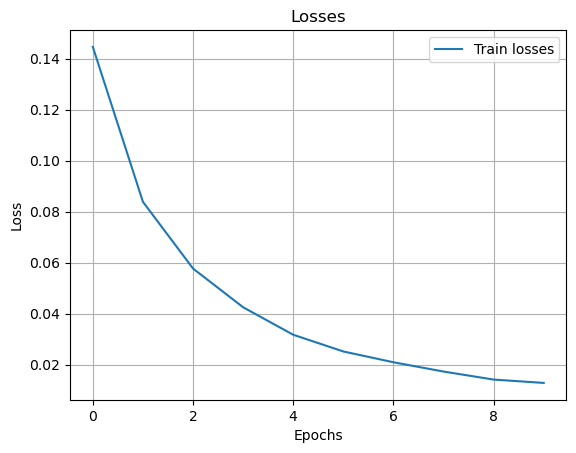

In [90]:
plt.plot(train_losses, label='Train losses')
plt.grid()
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

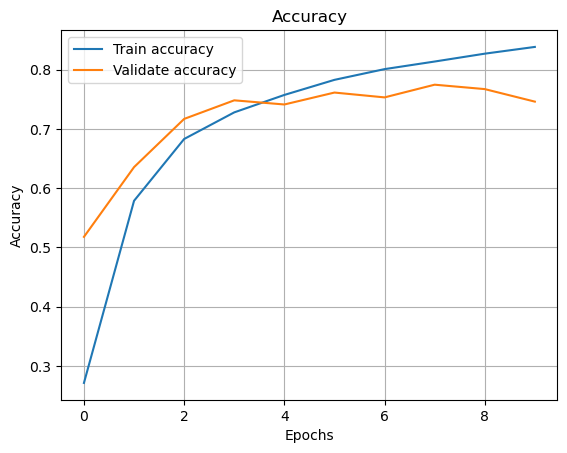

In [91]:
plt.plot(train_accs, label='Train accuracy')
plt.plot(valid_accs, label='Validate accuracy')
plt.grid()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

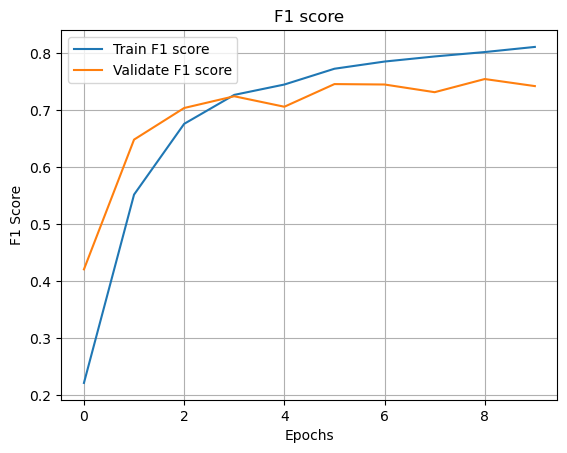

In [92]:
plt.plot(train_f1s, label='Train F1 score')
plt.plot(valid_f1s, label='Validate F1 score')
plt.grid()
plt.title('F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [93]:
torch.save(model, 'final_gru_model.pth')  #Модель и её веса сохраняются для дальнейшего использования, чтобы снова не ждать весь процесс обучения

In [94]:
tokens = list(map(lambda x: vocab.tokenize(x), custom_title))
X = torch.concat(list(map(lambda x: vocab.encode(x)[0], custom_title))).reshape(len(custom_title), -1)
pred = model(X.to(device)).argmax(dim=2)
tags = [vocab.tag_decode(pred[i], X[i]) for i in range(len(custom_title))]
visualize_ner(tokens, tags)

MDL
CMPN
SIZE
MAT
COL
CAP
NUM
насос дренажный patriot fq1200n 1200 вт 18000 л/час 
1.1.83 плита перекрытия колодца пп 10.2 усилен 
плита перекрытия п1 по серии ис-01-04 вып.2 
фанера большеформатная фк и фсф 
краска для бетона monopol color цвет синий 

